### Figure 1: Lightcurves of our Type IIP SN Sample
Plotting code to generate Figure 1, the collection of lightcurves for our sample

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.collections as mcoll
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from pathlib import Path
import pickle

from lltypeiip.config import config, SED_COLORS, SED_MARKERS
from lltypeiip.photometry import get_wise_lc_data, get_ztf_lc_data, convert_ZTF_mag_mJy
# from lltypeiip.photometry.plotting import plot_combined_lc
from lltypeiip.photometry.wise import subtract_wise_parity_baseline
from lltypeiip.photometry.ztf import convert_ZTF_mag_mJy
from lltypeiip.photometry.extinction import calculate_distance_modulus
from lltypeiip.sed.plotting import plot_sed
from lltypeiip.sed.build import _prepare_sed_xy

from alerce.core import Alerce

In [13]:
import warnings
warnings.filterwarnings('ignore')

plt.rcdefaults()
plt.rcParams['figure.dpi'] = 600 # change dpi for overleaf figures

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load data (ztf dicts, wise dicts, and SED dicts) for our SN sample.

In [15]:
sed_sample_path = "/home/cal/analam/Documents/LL_typeIIP/sed_sample.txt"

with open(sed_sample_path, 'r') as file:
    oids = [line.rstrip() for line in file]
print(f"{len(oids)} OIDs")
print(oids)

15 OIDs
['ZTF18abjndhh', 'ZTF19aadnxnl', 'ZTF19aarykkb', 'ZTF19acbwejj', 'ZTF19aclobbu', 'ZTF21aagtqna', 'ZTF21abnlhxs', 'ZTF21abouuat', 'ZTF21acpqqgu', 'ZTF22aativsd', 'ZTF22aaywnyg', 'ZTF22abtspsw', 'ZTF23aaxadel', 'ZTF23abaxtlq', 'ZTF23abnogui']


In [16]:
sed_dir = Path("/home/cal/analam/Documents/LL_typeIIP/data/tail_seds")

alerce = Alerce()

data = {} 

for oid in oids:
    print(f"Loading data for {oid}...")

    # load ztf
    ztf_resdict = get_ztf_lc_data(
        oid, alerce, doLC=False, doStamps=False, add_forced=True
    )
    ztf_resdict = convert_ZTF_mag_mJy(ztf_resdict, forced=True)

    # load wise
    wise_resdict = get_wise_lc_data(oid)

    # load sed
    sed_pkl = sed_dir / f"{oid}_tail_sed.pkl"
    if sed_pkl.exists():
        with open(sed_pkl, "rb") as f:
            sed_obj = pickle.load(f)
        sed = sed_obj.get("sed", sed_obj)
    else:
        print(f"  Warning: No SED found for {oid}")
        sed = None

    data[oid] = {
        "ztf": ztf_resdict,
        "wise": wise_resdict,
        "sed": sed
    }

print(f"\nLoaded data for {len(data)} objects")

Loading data for ZTF18abjndhh...
Saved ztf_resdict for ZTF18abjndhh to /home/cal/analam/Documents/LL_typeIIP/data/ztf_alerce
Loading data for ZTF19aadnxnl...
Saved ztf_resdict for ZTF19aadnxnl to /home/cal/analam/Documents/LL_typeIIP/data/ztf_alerce
Loading data for ZTF19aarykkb...
Saved ztf_resdict for ZTF19aarykkb to /home/cal/analam/Documents/LL_typeIIP/data/ztf_alerce
Loading data for ZTF19acbwejj...
Saved ztf_resdict for ZTF19acbwejj to /home/cal/analam/Documents/LL_typeIIP/data/ztf_alerce
Loading data for ZTF19aclobbu...
Saved ztf_resdict for ZTF19aclobbu to /home/cal/analam/Documents/LL_typeIIP/data/ztf_alerce
Loading data for ZTF21aagtqna...
Saved ztf_resdict for ZTF21aagtqna to /home/cal/analam/Documents/LL_typeIIP/data/ztf_alerce
Loading data for ZTF21abnlhxs...
Saved ztf_resdict for ZTF21abnlhxs to /home/cal/analam/Documents/LL_typeIIP/data/ztf_alerce
Loading data for ZTF21abouuat...
Saved ztf_resdict for ZTF21abouuat to /home/cal/analam/Documents/LL_typeIIP/data/ztf_alerce


#### Check individual light curves.

In [17]:
# plotting functions from lltypeiip.photometry.plotting

#########################################################################
## -------------- ZTF PHOTOMETRY PLOTTING FUNCTIONS ------------------- ##
##########################################################################

FILTER_COLORS = {1: "green", 2: "red", 3: "orange"}
FILTER_LABELS = {1: 'g', 2: 'r', 3: 'i'}
FILTER_MARKERS = {1: 'o', 2: 'X', 3: 'D'}
FILTER_SIZES = {1: 30, 2: 60, 3: 90}


def plot_forced_lc(resdict, oid="ZTF source", xlim=(None, None), ax=None, show=True, flux=False,
                   ylim=(None, None), SNU=5.0):
    """
    Plot ZTF forced photometry light curves (apparent magnitude or flux).

    Parameters
    ----------
    resdict : dict
        Dictionary containing forced photometry data by filter.
        Expected structure:
            {
              "ZTF_g": {"mjd": [...], "mag": [...], "mag_err": [...],
                        "mag_ul": [...], "flux": [...], "flux_err": [...],
                        "flux_mJy": [...], "flux_err_mJy": [...],
                        "lim_flux_mJy": [...]},
              "ZTF_r": {...},
              ...
            }
    oid : str, optional
        Object ID or name to show in plot title.
    xlim : tuple, optional
        (xmin, xmax) for x-axis (MJD). Default (None, None) = auto.
    ax : matplotlib.axes.Axes, optional
        Existing matplotlib axis. If None, a new figure is created.
    show : bool, optional
        Whether to display the plot. If False and ax is provided, returns the axis.
    flux : bool, optional
        If True, plots in flux (mJy) instead of magnitudes.
    ylim : tuple, optional
        (ymin, ymax) for y-axis. Default (None, None) = auto.
    SNU : float, optional
        Signal-to-noise multiplier for computing flux limits
        when explicit limit fields are missing (default 5).

    Notes
    -----
    - Magnitude plots invert the y-axis (bright = up).
    - Handles both detections and non-detections (upper limits).
    - If `flux=True`, tries to use mJy fields first, otherwise raw DN units.
    """

    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(9,5))
        created_ax = True

    # Use colors and markers from config
    colors = SED_COLORS
    markers = SED_MARKERS

    all_mjd = []
    all_y = []

    # avoid duplicate legend entries for limits per filter
    shown_limit_label = set()

    # if flux=True, check if mJy fields are available
    use_mJy = flux and any(("flux_mJy" in d) for d in resdict.values())

    for filt, data in resdict.items():
        color = colors.get(filt,"black")

        # --- Detections ---
        mask_det = ~np.isnan(data["mag"])
        if np.any(mask_det):
            if flux:
                if "flux_mJy" in data and "flux_err_mJy" in data:
                    yvals = data["flux_mJy"][mask_det]
                    yerrs = data["flux_err_mJy"][mask_det]
                else:
                    yvals = data["flux"][mask_det]       # DN fallback
                    yerrs = data["flux_err"][mask_det]   # DN fallback
            else:
                yvals = data["mag"][mask_det]
                yerrs = data["mag_err"][mask_det]

            ax.errorbar(
                data["mjd"][mask_det],
                yvals,
                yerr=yerrs,
                color=color, label=filt,
                marker = markers.get(filt, "o"),
                linestyle='none'
            )
            all_mjd.extend(data["mjd"][mask_det])
            all_y.extend(yvals)

        # --- Non-detections (limits) ---
        # Use mag_ul when plotting mags; fall back to limiting_mag if mag_ul missing.
        # In flux space, prefer provided lim_flux_mJy; else compute snu*flux_err in same units.
        mask_nondet = np.isnan(data["mag"])

        if np.any(mask_nondet):
            if flux:
                if use_mJy and "lim_flux_mJy" in data:
                    yvals_lim = data["lim_flux_mJy"][mask_nondet]
                else:
                    yvals_lim = SNU * data['flux_err'][mask_nondet]
            else:
                if "mag_ul" in data:
                    yvals_lim = data["mag_ul"][mask_nondet]
                else:
                    yvals_lim = data.get("limiting_mag", np.full_like(data["mjd"], np.nan))[mask_nondet]

            # only plot finite limits
            finite = np.isfinite(yvals_lim)

            ax.scatter(
                data["mjd"][mask_nondet][finite],
                yvals_lim[finite],
                marker="v", alpha=0.5, color=color,
                label=f"lim. mag {filt}" if filt not in shown_limit_label else None,
                s=40
            )
            shown_limit_label.add(filt)
            all_mjd.extend(data["mjd"][mask_nondet][finite])
            all_y.extend(yvals_lim[finite])

    # --- Auto limits ---
    if all_mjd and all_y:
        min_mjd = xlim[0] if xlim[0] is not None else None
        max_mjd = xlim[1] if xlim[1] is not None else None

        if min_mjd is not None and max_mjd is not None:
            ax.set_xlim(min_mjd, max_mjd)

        if ylim[0] is not None and ylim[1] is not None:
            ax.set_ylim(ylim[0], ylim[1])
        else:
            # y-range: min/max mags + padding
            ymin = np.nanmin(all_y) - 2.0
            ymax = np.nanmax(all_y) + 1.0

            if flux:
                ax.set_ylim(ymin, ymax)
            else:   
                ax.set_ylim(ymax, ymin)  # flip so bright = up

    if created_ax:
        ax.set_title(f"ZTF Light Curve: {oid}", fontsize=16)
        ax.set_xlabel("MJD", fontsize=14)
        if flux:
            ax.set_ylabel("Flux (mJy)", fontsize=14)
        else:
            ax.set_ylabel("Apparent magnitude", fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.4)
        
        if show:
            plt.show()
        
        return ax.get_ylim()[0], ax.get_ylim()[1]

    if not created_ax:
        return ax

##########################################################################
## -------------- WISE PHOTOMETRY PLOTTING FUNCTIONS ------------------ ##
##########################################################################

def plot_wise_lc(resdict, oid="ZTF source", xlim=(None, None), ax=None, show=True, subtract_parity_baseline=False, 
                 baseline_dt=200, show_baselines=False, clip_negatives=False):

    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(9,5))
        created_ax = True

    colors = {1:"navy",2:"dodgerblue"}
    markers = {1:"s",2:"s"}

    if subtract_parity_baseline:
        resdict = subtract_wise_parity_baseline(resdict, dt=baseline_dt, clip_negatives=clip_negatives)
        for fid, data in zip([1,2], [("b1_times","b1_fluxes","b1_fluxerrs"), ("b2_times","b2_fluxes","b2_fluxerrs")]):
            color = colors.get(fid,"black")
            min_det = np.nanmin(resdict[data[1]])
            max_det = np.nanmax(resdict[data[1]])
            # --- Detections ---
            mask_det = ~np.isnan(resdict[data[1]])
            if np.any(mask_det):
                ax.errorbar(
                    resdict[data[0]][mask_det],
                    resdict[data[1]][mask_det],
                    yerr=resdict[data[2]][mask_det],
                    fmt="o", color=color, label=f"W{fid}",
                    marker = markers.get(fid, "o"),
                )
                even_base = resdict[f"{data[0][:2]}_even_baseline"]
                odd_base = resdict[f"{data[0][:2]}_odd_baseline"]

                # optional show baselines on plot
                if show_baselines:
                    ax.axhline(even_base, color=color, linestyle='--', alpha=0.5, label=f"{fid} even baseline")
                    ax.axhline(odd_base, color=color, linestyle=':', alpha=0.5, label=f"{fid} odd baseline")

    else:
        for fid, data in zip([1,2], [("b1_times","b1_fluxes","b1_fluxerrs"), ("b2_times","b2_fluxes","b2_fluxerrs")]):
            color = colors.get(fid,"black")

            # --- Detections ---
            mask_det = ~np.isnan(resdict[data[1]])
            if np.any(mask_det):
                ax.errorbar(
                    resdict[data[0]][mask_det],
                    resdict[data[1]][mask_det],
                    yerr=resdict[data[2]][mask_det],
                    fmt="o", color=color, label=f"W{fid}",
                    marker = markers.get(fid, "o"),
                )

    if created_ax:
        ax.set_title(f"WISE Light Curve: {oid}", fontsize=16)
        ax.set_xlabel("MJD", fontsize=14)
        ax.set_ylabel("WISE flux (mJy)", fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.4)

        if xlim[0] is not None and xlim[1] is not None:
            ax.set_xlim(xlim[0], xlim[1])
        
        if show:
            plt.show()
        
        return min_det, max_det

    if not created_ax:
        return ax


In [18]:
###########################################################################
######## ---------- COMBINED PLOTTING FUNCTIONS --------------- ###########
###########################################################################

def plot_combined_lc(ztf_resdict, wise_resdict, oid="ZTF+WISE source",
            xlim=(None, None), ztf_flux=False, mode="stacked", scale_wise=True,
            baseline_ref="ztf", baseline_dt=100, ref_band="r", logy=False,
            savepath=None, ax=None, labels=True, inset_labels=False, 
            mark_tail_start=False, mark_plateau_end=False,  mark_custom_mjd=None,
            marker_scale=1.0
        ):   
    """
    Plot ZTF + WISE light curves.
    
    Parameters
    ----------
    ztf_resdict : dict
        ZTF results dictionary from get_ztf_lc_data().
    wise_resdict : dict
        WISE results dictionary from get_wise_lc_data().
    oid : str
        Object identifier for plot title.
    xlim : tuple
        (min_mjd, max_mjd) to set x-axis limits.
    ztf_flux : bool
        If True, plot ZTF in flux (mJy). If False, plot in magnitude.
    mode : str
        "stacked" → two panels (default).
        "overlay" → single panel with both ZTF and WISE.
    scale_wise : bool
        If True, scale WISE fluxes to match ZTF peak in reference band.
    ref_band : str
        Reference band for scaling WISE fluxes ("g", "r", or "i").
    """
    
    # Helper: log-safe clipping
    def log_safe(y, yerr=None):
        y = np.asarray(y, dtype=float)
        if np.all(~np.isfinite(y)) or np.all(y <= 0):
            return y, yerr
        positive = y[y > 0]
        floor = np.nanmin(positive) * 0.1
        y_clipped = np.where(y > 0, y, floor)
        if yerr is not None:
            # prevent errorbars from crossing below floor
            yerr = np.minimum(yerr, y_clipped * 0.95)
            return y_clipped, yerr
        return y_clipped, None
    
    # helper for v lines
    def vline_with_label(ax, x, label, *, y=0.02, dx_pts=-12,
                     line_kw=None, text_kw=None):
        line_kw = {} if line_kw is None else dict(line_kw)
        text_kw = {} if text_kw is None else dict(text_kw)

        ax.axvline(x, **line_kw)

        ax.annotate(
            label,
            xy=(x, y), xycoords=ax.get_xaxis_transform(),   # x=data, y=axes fraction
            xytext=(dx_pts, 0), textcoords="offset points", # fixed visual offset
            rotation=90,
            ha="center", va=("bottom" if y < 0.5 else "top"),
            clip_on=False,
            **text_kw
        )


    # x-axis range (detections)
    xlim=(ztf_resdict["lc_det"].mjd.min() , ztf_resdict["lc_det"].mjd.max())
    
    # y-axis range (detectiongs)
    det_flux_vals = []
    for filt, data in ztf_resdict["forced"].items():
        mask_det = ~np.isnan(data["mag"])
        if np.any(mask_det):
            yerrs = data["flux_err_mJy"][mask_det]
            yvals = data["flux_mJy"][mask_det]
            ymins = yvals - yerrs
            ymaxs = yvals + yerrs
            det_flux_vals.extend(ymins)
            det_flux_vals.extend(ymaxs)
    
    ylim = (min(det_flux_vals), max(det_flux_vals))
    
    min_mjd = xlim[0] - 15 if xlim[0] is not None else None
    max_mjd = mark_custom_mjd + 30 if xlim[1] is not None else None

    w = wise_resdict.copy()

    if mode == "stacked":
        # ---------------------------
        # Two-panel figure
        # ---------------------------
        fig, (ax1, ax2) = plt.subplots(
            2, 1, figsize=(10,8), sharex=True,
            gridspec_kw={"height_ratios": [2, 1]}
        )

        # -----------------
        # Top panel: ZTF LC
        # -----------------
        if ztf_flux:
            ztf_resdict = convert_ZTF_mag_mJy(ztf_resdict, forced=True)

            # clip fluxes for log scale
            if logy:
                for band, data in ztf_resdict["forced"].items():
                    data["flux_mJy"], data["flux_err_mJy"] = log_safe(
                        data["flux_mJy"], data["flux_err_mJy"]
                    )

            plot_forced_lc(ztf_resdict['forced'], oid=ztf_resdict['oid'], xlim=(min_mjd, max_mjd), ax=ax1, show=False, flux=True)
            ax1.set_ylabel("ZTF flux (mJy)", fontsize=14)
            ax1.grid(True, alpha=0.4)
        else:
            plot_forced_lc(ztf_resdict['forced'], oid=ztf_resdict['oid'], xlim=(min_mjd, max_mjd), ax=ax1, show=False)
            ax1.set_ylabel("Apparent magnitude", fontsize=14)

        if logy and ztf_flux:
            ax1.set_yscale("log")
        
        ax1.legend()
        ax1.grid(True, alpha=0.4)

        # -----------------
        # Bottom panel: WISE LC
        # -----------------
        if wise_resdict == {}:
            pass
        else:

            if logy:
                w["b1_fluxes"], w["b1_fluxerrs"] = log_safe(w["b1_fluxes"], w["b1_fluxerrs"])
                w["b2_fluxes"], w["b2_fluxerrs"] = log_safe(w["b2_fluxes"], w["b2_fluxerrs"])

            plot_wise_lc(wise_resdict, oid=ztf_resdict['oid'], subtract_parity_baseline=scale_wise, xlim=(min_mjd, max_mjd), ax=ax2, show=False)
            ax2.set_ylabel("WISE flux scaled (mJy)" if scale_wise else "WISE flux (mJy)", fontsize=14)
            ax2.grid(True, alpha=0.4)
            ax2.set_xlabel("MJD", fontsize=14)

            if logy:
                ax2.set_yscale("log")

        # change style for stacked
        # 1. Fix scatter points (PathCollection)
        for ax in [ax1, ax2]:
            for col in ax.collections:
                if isinstance(col, mcoll.PathCollection):
                    fcs = col.get_facecolors()
                    if fcs is None or len(fcs) == 0:
                        continue
                    r, g, b, _ = fcs[0]
                    col.set_facecolor((r, g, b, 0.3))
                    col.set_edgecolor((r, g, b, 0.3))
                    col.set_linewidth(1.2)
                    col.set_sizes([20])

            # 2. Fix errorbar markers (Line2D)
            for line in ax.lines:
                mfc = line.get_markerfacecolor()
                mec = line.get_markeredgecolor()
                if mfc is None or mfc == "none":
                    continue
                if isinstance(mfc, (tuple, list)) and len(mfc) == 4:
                    r, g, b, _ = mfc
                elif isinstance(mfc, str):
                    import matplotlib.colors as mcolors
                    r, g, b, _ = mcolors.to_rgba(mfc)
                else:
                    continue
                line.set_markerfacecolor((r, g, b, 0.3))   # semi-transparent fill
                line.set_markeredgecolor((r, g, b, 1.0))   # solid outline
                line.set_markeredgewidth(1.2)
                line.set_markersize(7)

        ax1.legend()
        ax2.legend()
        fig.subplots_adjust(hspace=0.0)
        fig.suptitle(f"ZTF + WISE Light Curve: {oid}", fontsize=16, y=0.93)

        if mark_tail_start and oid in m_dict:
            tail_start = m_dict[oid]
            for ax in (ax1, ax2):
                vline_with_label(
                    ax, tail_start, "Tail Start",
                    y=0.95, dx_pts=-10,
                    line_kw=dict(color="black", linestyle="--", alpha=0.7),
                    text_kw=dict(fontsize=9, color="black"),
                )
        if mark_plateau_end and oid in m_dict:
            plateau_end = m_dict[oid]
            for ax in (ax1, ax2):
                vline_with_label(
                    ax, plateau_end, f"Plateau End ({plateau_end:.1f})",
                    y=0.05, dx_pts=-10,
                    line_kw=dict(color="black", linestyle="-.", alpha=0.7),
                    text_kw=dict(fontsize=9, color="black"),
                )
        if mark_custom_mjd is not None:
            print(f"Marking custom MJD: {mark_custom_mjd}")
            for ax in (ax1, ax2):
                vline_with_label(
                    ax, mark_custom_mjd, f"SED ({mark_custom_mjd:.1f})",
                    y=0.2, dx_pts=-12,
                    line_kw=dict(color="red", alpha=0.7),
                    text_kw=dict(fontsize=9, color="black"),
                )
        if savepath:
            plt.savefig(savepath, format="pdf", bbox_inches="tight")
            print(f"Saved plot to {savepath}")
        else:
            plt.show()

    elif mode == "overlay":
        # ---------------------------
        # Single-panel figure
        # ---------------------------
        created_ax = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(10,6))
            created_ax = True
        else:
            fig = ax.figure

        # --- ZTF LC ---
        if ztf_flux:
            # print("Converting ZTF mag to mJy...")
            ztf_resdict = convert_ZTF_mag_mJy(ztf_resdict, forced=True)

            if logy:
                for band, data in ztf_resdict["forced"].items():
                    data["flux_mJy"], data["flux_err_mJy"] = log_safe(
                        data["flux_mJy"], data["flux_err_mJy"]
                    )

            plot_forced_lc(ztf_resdict['forced'], oid=ztf_resdict['oid'], xlim=(min_mjd, max_mjd), ax=ax, show=False, flux=True)
        else:
            plot_forced_lc(ztf_resdict['forced'], oid=ztf_resdict['oid'], xlim=(min_mjd, max_mjd), ax=ax, show=False)

        # --- WISE LC ---
        if wise_resdict == {}:
            pass
        else:

            if logy:
                w["b1_fluxes"], w["b1_fluxerrs"] = log_safe(w["b1_fluxes"], w["b1_fluxerrs"])
                w["b2_fluxes"], w["b2_fluxerrs"] = log_safe(w["b2_fluxes"], w["b2_fluxerrs"])

            plot_wise_lc(wise_resdict, oid=ztf_resdict['oid'], subtract_parity_baseline=scale_wise, xlim=(min_mjd, max_mjd), ax=ax, clip_negatives=True, show=False)

        # change style for overlay
        # 1. Fix scatter points (PathCollection)
        for col in ax.collections:
            if isinstance(col, mcoll.PathCollection):
                fcs = col.get_facecolors()
                if fcs is None or len(fcs) == 0:
                    continue
                r, g, b, _ = fcs[0]
                col.set_facecolor((r, g, b, 0.3))
                col.set_edgecolor((r, g, b, 0.3))
                col.set_linewidth(1.2)
                old_sizes = col.get_sizes()
                if len(old_sizes) > 0:
                    # Get actual number of points in the collection
                    n_points = len(col.get_offsets())
                    new_size = old_sizes[0] * marker_scale
                    # Create array with correct length
                    col.set_sizes(np.full(n_points, new_size))

        # 2. Fix errorbar markers (Line2D)
        for line in ax.lines:
            mfc = line.get_markerfacecolor()
            mec = line.get_markeredgecolor()
            if mfc is None or mfc == "none":
                continue
            if isinstance(mfc, (tuple, list)) and len(mfc) == 4:
                r, g, b, _ = mfc
            elif isinstance(mfc, str):
                import matplotlib.colors as mcolors
                r, g, b, _ = mcolors.to_rgba(mfc)
            else:
                continue
            line.set_markerfacecolor((r, g, b, 0.3))   # semi-transparent fill
            line.set_markeredgecolor((r, g, b, 1.0))   # solid outline
            line.set_markeredgewidth(1.2)
            line.set_markersize(7 * marker_scale)
    
        if labels:
            ax.set_title(f"ZTF + WISE Light Curve: {oid}", fontsize=16)
            ax.set_xlabel("MJD", fontsize=14)
            ax.set_ylabel("Flux (mJy)", fontsize=14)
        
            handles, labels = ax.get_legend_handles_labels()
            # keep only ZTF detections and WISE bands
            keep = ["ZTF_g", "ZTF_r", "ZTF_i", "W1", "W2"]
            filtered = [(h, l) for h, l in zip(handles, labels) if l in keep]

            if filtered:
                handles, labels = zip(*filtered)
                ax.legend(handles, labels, loc="upper right")
        if not labels:
            ax.tick_params(labelbottom=True, labelleft=False)
            ax.set_xlabel("MJD", fontsize=10)

            # change marker size for inset
            if not inset_labels:
                for col in ax.collections:
                    if isinstance(col, mcoll.PathCollection):
                        col.set_sizes([7 * marker_scale])

                # ---- resize errorbar markers ----
                for line in ax.lines:
                    if line.get_marker() not in (None, "", "None"):
                        line.set_markersize(2 * marker_scale)


        ax.grid(True, alpha=0.4)

        if logy:
            ax.set_yscale("log")
            ymin, ymax = ylim[0], ylim[1]

            log_padding = 0.1 # 10% of log range
            log_ymin, log_ymax = np.log10(ymin), np.log10(ymax)
            log_range = log_ymax - log_ymin

            new_ymin = 10**(log_ymin - log_range * log_padding)
            new_ymax = 10**(log_ymax + log_range * log_padding)
            ax.set_ylim(new_ymin, new_ymax)


        if mark_tail_start:
            params_path = Path(config.paths.params)
            params = pd.read_csv(params_path)
            m = params[['name', 'plateauend', 'tailstart']].dropna()
            m_dict = dict(zip(m['name'].astype(str), m['tailstart'].astype(float)))
            if oid in m_dict:
                tail_start = m_dict[oid]
                if not inset_labels:
                    ax.axvline(tail_start, color='black', linestyle='--', alpha=0.7, linewidth=1.3)
                else:
                    ax.axvline(tail_start, color='black', linestyle='--', alpha=0.7)
                if inset_labels:
                    plateau_end = m_dict[oid]
                    vline_with_label(
                        ax, tail_start, "Tail Start",
                        y=0.02, dx_pts=-5,
                        line_kw=dict(color="black", linestyle="--", alpha=0.7),
                        text_kw=dict(fontsize=9, color="black"),
                    )
        
        if mark_plateau_end:
            params_path = Path(config.paths.params)
            params = pd.read_csv(params_path)
            m = params[['name', 'plateauend', 'tailstart']].dropna()
            m_dict = dict(zip(m['name'].astype(str), m['plateauend'].astype(float)))
            if oid in m_dict:
                plateau_end = m_dict[oid]
                if not inset_labels:
                    ax.axvline(plateau_end, color='black', linestyle='-.', alpha=0.7, linewidth=1.3)
                else:
                    ax.axvline(plateau_end, color='black', linestyle='-.', alpha=0.7)
                if inset_labels:
                    vline_with_label(
                        ax, plateau_end, "Plateau End",
                        y=0.02, dx_pts=-5,
                        line_kw=dict(color="black", linestyle="-.", alpha=0.7),
                        text_kw=dict(fontsize=9, color="black"),
                    )

        if mark_custom_mjd is not None:
            if inset_labels:
                vline_with_label(
                            ax, mark_custom_mjd, f"SED MJD ({mark_custom_mjd:.0f})",
                            y=0.2, dx_pts=-10,
                            line_kw=dict(color="red", alpha=0.7, linewidth=3.5),
                            text_kw=dict(fontsize=10, color="black", fontweight='bold'),
                        )
            else:
                ax.axvline(mark_custom_mjd, color='red', alpha=0.7, linewidth=2.5, label=f"SED")
            
        if savepath:
            fig.savefig(savepath, bbox_inches="tight")
            print(f"Saved plot to {savepath}")
        elif created_ax:
            plt.show()

        return ax
    else:
        raise ValueError("Invalid mode. Choose 'stacked' or 'overlay'.")

<Axes: title={'center': 'ZTF + WISE Light Curve: ZTF22aaywnyg'}, xlabel='MJD', ylabel='Flux (mJy)'>

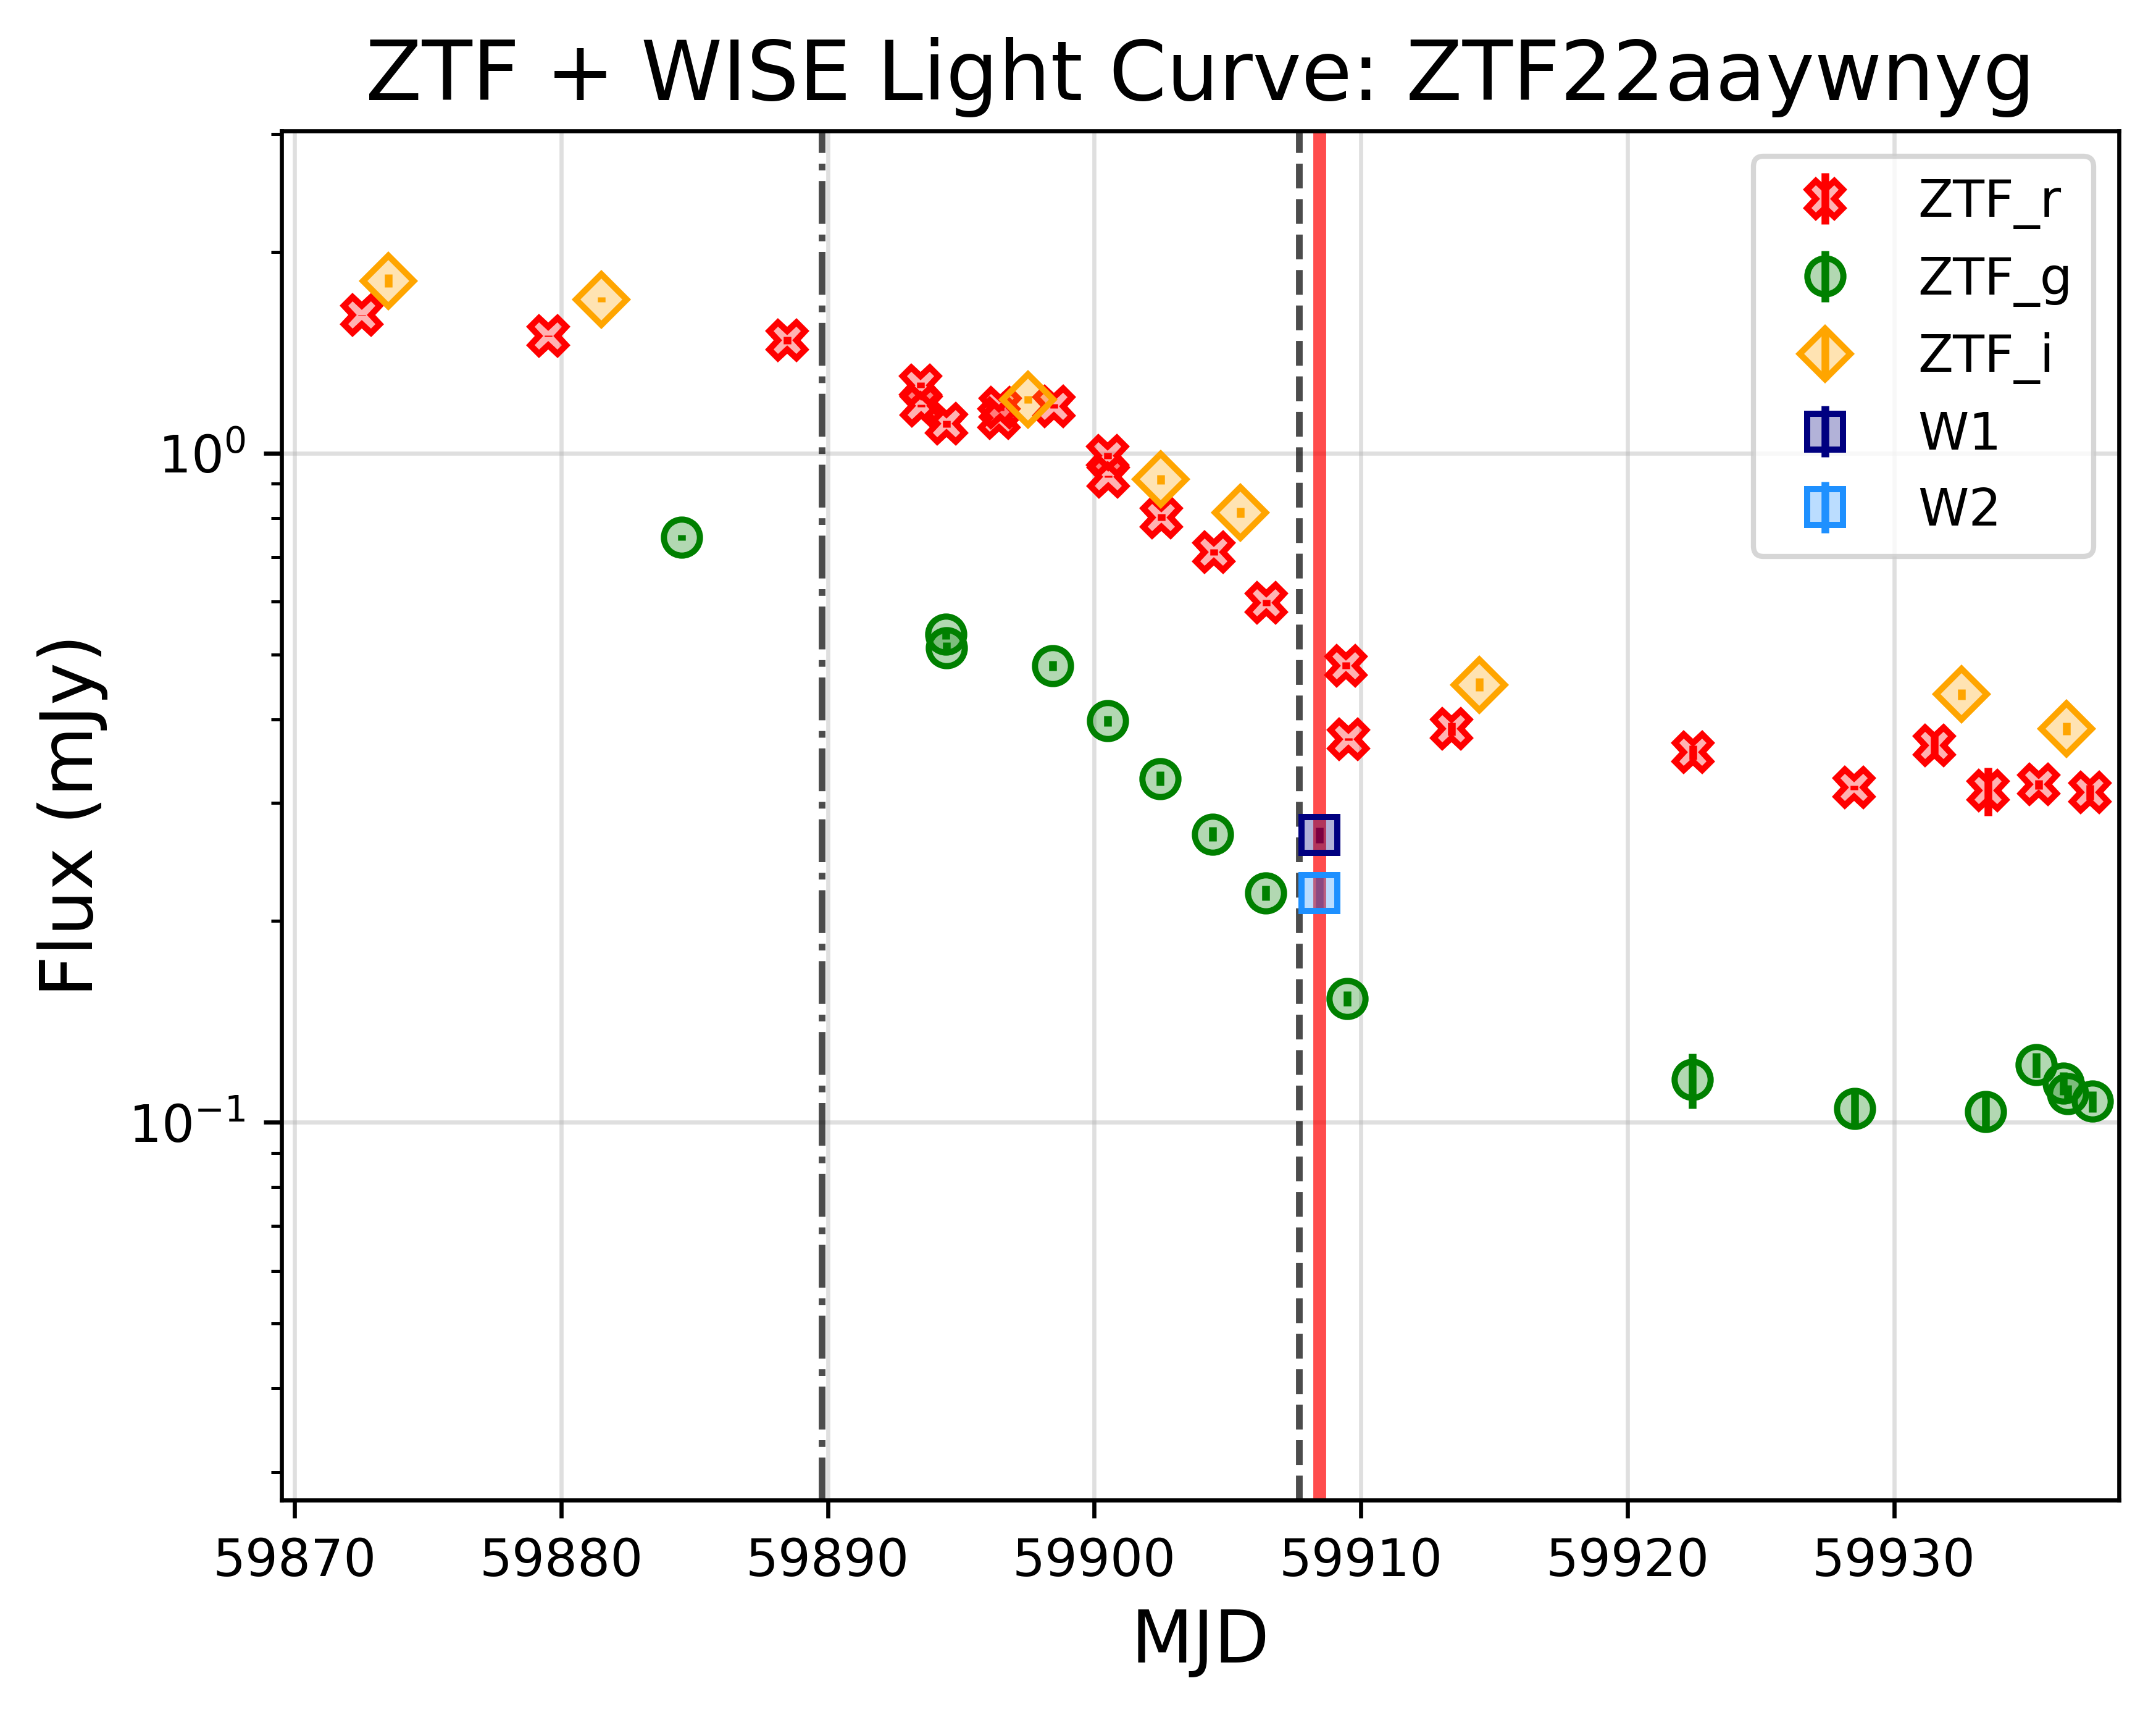

In [19]:
sample_oid = "ZTF22aaywnyg"

ztf_resdict = data[sample_oid]["ztf"]
wise_resdict = data[sample_oid]["wise"]
    
fig, ax = plt.subplots(1, 1)

plot_combined_lc(
        ztf_resdict,
        wise_resdict,
        oid=sample_oid,
        ax=ax,
        ztf_flux=True,
        mode="overlay",
        scale_wise=True,
        logy=True,
        labels=True,
        mark_plateau_end=True,
        mark_tail_start=True,
        mark_custom_mjd=data[sample_oid]['sed']['mjd'],
    )

#### Create multi-panel light curve figure.

In [24]:
def create_shared_legend_lc():
    """Create legend handles for light curve figure."""
    handles = [
        Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=(0, 0.5, 0, 0.6),
               markeredgecolor=(0, 0.5, 0, 1.0),
               markeredgewidth=1.2,
               markersize=8, label='ZTF g'),
        Line2D([0], [0], marker='X', color='w', 
               markerfacecolor=(1, 0, 0, 0.6),
               markeredgecolor=(1, 0, 0, 1.0),
               markeredgewidth=1.2,
               markersize=8, label='ZTF r'),
        Line2D([0], [0], marker='D', color='w', 
               markerfacecolor=(1, 0.65, 0, 0.6),
               markeredgecolor=(1, 0.65, 0, 1.0),
               markeredgewidth=1.2,
               markersize=8, label='ZTF i'),
        Line2D([0], [0], marker='s', color='w', 
               markerfacecolor=(0, 0, 0.5, 0.6),
               markeredgecolor=(0, 0, 0.5, 1.0),
               markeredgewidth=1.2,
               markersize=8, label='W1'),
        Line2D([0], [0], marker='s', color='w', 
               markerfacecolor=(0.12, 0.56, 1, 0.6),
               markeredgecolor=(0.12, 0.56, 1, 1.0),
               markeredgewidth=1.2,
               markersize=8, label='W2'),
        Line2D([0], [0], marker='v', color='w',
               markerfacecolor=(0.5, 0.5, 0.5, 0.6),
               markeredgecolor=(0.5, 0.5, 0.5, 0.6),
               markeredgewidth=1.2,
               linestyle='none', 
               markersize=7, label='Upper limit'),
        Line2D([0], [0], color='black', linestyle='-.', linewidth=1.5, 
               label='Plateau End'),
        Line2D([0], [0], color='black', linestyle='--', linewidth=1.5, 
               label='Tail Start'),
        Line2D([0], [0], color='red', linestyle='-', linewidth=2.5,
               alpha=0.7, label='SED Epoch'),
    ]
    return handles

In [25]:
n_candidates = len(oids)
ncols = 3
nrows = int(np.ceil(n_candidates / ncols))
figsize = (18, 16) 

fig, axes = plt.subplots(
    nrows, ncols, 
    figsize=figsize,
    sharex=False, 
    sharey=False,
    gridspec_kw={
        'hspace': 0.3,
        'wspace': 0.15,
        'left': 0.07,
        'right': 0.98,    
        'top': 0.98,      
        'bottom': 0.06    
    }
)

axes = axes.flatten()

for idx, oid in enumerate(oids):
    ax = axes[idx]
    ztf_resdict = data[oid]["ztf"]
    wise_resdict = data[oid]["wise"]
    
    plot_combined_lc(
        ztf_resdict,
        wise_resdict,
        oid=oid,
        ax=ax,
        ztf_flux=True,
        mode="overlay",
        scale_wise=True,
        logy=True,
        labels=False,
        mark_plateau_end=True,
        mark_tail_start=True,
        mark_custom_mjd=data[oid]['sed']['mjd'],
        marker_scale=3
    )
    
    ax.set_title(oid, fontsize=16)  

    ax.tick_params(axis='x', which='major', labelsize=12) 
    ax.tick_params(axis='y', which='major', labelsize=14) 
    
    # Y-labels
    if idx % ncols == 0:
        ax.set_ylabel("Flux (mJy)", fontsize=14)
        ax.tick_params(labelleft=True)
    else:
        ax.set_ylabel("")
        ax.tick_params(labelleft=True)
    
    # X-labels
    if idx >= (nrows - 1) * ncols:
        ax.set_xlabel("MJD", fontsize=14)
    else:
        ax.set_xlabel("")
    
    # Remove individual legend
    legend = ax.get_legend()
    if legend:
        legend.remove()

    if oid == "ZTF19aadnxnl": 
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(0.04, ymax)

    if oid == "ZTF21abouuat": 
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(0.02, ymax)
    
    if oid == "ZTF22aaywnyg": 
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(0.05, ymax)
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(59800, xmax)

    if oid == "ZTF22abtspsw": 
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(0.005, ymax)

    ax.xaxis.set_major_locator(MultipleLocator(50))
    ax.xaxis.set_minor_locator(MultipleLocator(10))

    ax.yaxis.set_minor_locator(plt.LogLocator(subs='auto'))

    # Tick appearance
    ax.tick_params(
        axis='both', 
        which='major',
        direction='in',
        length=8,    
        width=2,
        top=False, right=False   
    )
    
    ax.tick_params(
        axis='both',
        which='minor',
        direction='in',
        length=5,
        width=1.5,
        top=False, right=False
    )
    
    ax.grid(False)

legend_handles = create_shared_legend_lc()
fig.legend(
    handles=legend_handles,
    loc='lower center',
    ncol=9,
    frameon=True,
    fontsize=16,
    bbox_to_anchor=(0.5, -0.005)
)
plt.savefig("Figure1_LightCurves_15_SN.pdf", dpi=600, bbox_inches='tight')
print("Saved Figure 1: Light Curves (15 candidates)")
plt.show()

Saved Figure 1: Light Curves (15 candidates)
